In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

''' inputs '''
T=3.0 # horizon length 
N=1 # number of cars 
u_max=1.0 # free flow speed
rho_jam=1.0 # jam density
L=N # road length
CFL=0.75    # CFL<1
EPS=0.45    # EPS<0.5

def solution(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,Nt):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,Nt]=sol[(j-1)*(Nt+1)+Nt]
        V[j,Nt]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
    for n in range(0,Nt):
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
        u[0,n]=u[Nx,n]
        Q[0,n]=Q[Nx,n]
    rho[0,Nt]=rho[Nx,Nt]
    V[0,Nt]=V[Nx,Nt]
    
    return 0

def convergence(guess,sol):
    def solution2(sol,rho,u):
        for j in range(0,Nx):
            for n in range(0,Nt):
                rho[j,n]=sol[j*(Nt+1)+n]
                u[j,n]=sol[(Nt+1)*Nx+j*Nt+n]
            rho[j,Nt]=sol[j*(Nt+1)+Nt]
        return 0
    rho=np.zeros((Nx,Nt+1))
    u=np.zeros((Nx,Nt))
    solution2(guess,rho,u)
    rho_mfg=np.zeros((Nx,Nt+1))
    u_mfg=np.zeros((Nx,Nt))
    solution2(sol,rho_mfg,u_mfg)
    error=np.linalg.norm(rho_mfg-rho,ord=1)/np.linalg.norm(rho_mfg,ord=1)+np.linalg.norm(u_mfg-u,ord=1)/np.linalg.norm(u_mfg,ord=1)
#     error=np.linalg.norm(rho_mfg-rho,ord=1)+np.linalg.norm(u_mfg-u,ord=1)
    return error


def plotting(t,x,y,rho,u,V,Q,Nx_list,Error_list):
    tt, xx = np.meshgrid(t, x)
    fig = plt.figure(figsize=(6, 5), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('density')
    ax.invert_xaxis()

    plt.figure(figsize=(13, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
    plt.subplot(2,3,1)
    plt.plot(y,rho[:,0],'b',label='density')
    plt.plot(y,u[:,0],'g',label='speed')
    plt.plot(x,V[:,0],'r',label='Optimal cost')
    plt.grid()
    plt.title("t=0.0")
    plt.xlabel('x')
    
    plt.subplot(2,3,2)
    plt.plot(y,rho[:,int(Nt/3)],'b',label='density')
    plt.plot(y,u[:,int(Nt/3)],'g',label='speed')
    plt.plot(x,V[:,int(Nt/3)],'r',label='Optimal cost')
    plt.grid()
    plt.title("t={t}".format(t=round(t[int(Nt/3)],3)))
    plt.xlabel('x')
    
    plt.subplot(2,3,3)
    plt.plot(y,rho[:,int(Nt/2)],'b',label='density')
    plt.plot(y,u[:,int(Nt/2)],'g',label='speed')
    plt.plot(x,V[:,int(Nt/2)],'r',label='Optimal cost')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("t={t}, T={T}".format(t=round(t[int(Nt/2)],3),T=T))
    plt.xlabel('x')
    
    plt.subplot(2,3,4)
    plt.scatter(rho[:,0],Q[:,0],s=5,label='flow-density')
    plt.xlabel('density')
    plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (t=0)")
    
    plt.subplot(2,3,5)
    plt.scatter(rho[:,int(Nt/3)],Q[:,int(Nt/3)],s=5,label='flow-density')
    plt.xlabel('density')
    plt.grid()
    plt.title("Fundamental diagram (t={t})".format(t=round(t[int(Nt/3)],3)))
    
    plt.subplot(2,3,6)
    plt.scatter(rho[:,int(Nt/2)],Q[:,int(Nt/2)],s=5,label='flow-density')
    plt.xlabel('density')
    plt.grid()
    plt.title("Fundamental diagram (t={t})".format(t=round(t[int(Nt/2)],3)))

    plt.figure()
    plt.plot(Nx_list,Error_list)
    plt.xlabel('Spatial grid size')
    plt.ylabel('error')
    plt.grid()
    plt.title("convergence of solution algorithm")

    return 0

def solve_grid(old_Nx,old_Nt,mu,guess,sol,error_list,nx_list):
    Nx=2*old_Nx; new_Nt=2*old_Nt
    dx=L/Nx # spatial step size
    if mu==0.0:
        dt=min(T/new_Nt,CFL*dx/abs(u_max)) # temporal step size
    else:
        dt=min(T/new_Nt,CFL*dx/abs(u_max),EPS*(dx**2)/mu) 
    x=np.linspace(0,L,Nx+1)
    t=np.arange(0,T,dt)
    old_Nt=int(len(t)/2)
    Nt=2*old_Nt
    print('Nx={Nx}, Nt={Nt}'.format(Nx=Nx,Nt=Nt))
    print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
    error=convergence(guess,sol)
    error_list.append(error)
    nx_list.append(Nx)
    
    return Nx,Nt



## LWR

******* solve in finer grid 1 ********
Nx=30, Nt=120
dx=0.033, dt=0.025
******* solve in finer grid 2 ********
Nx=60, Nt=240
dx=0.017, dt=0.013
******* solve in finer grid 3 ********
Nx=120, Nt=480
dx=0.008, dt=0.006
******* solve in finer grid 4 ********
Nx=240, Nt=960
dx=0.004, dt=0.003
******* solve in finer grid 5 ********
Nx=480, Nt=1920
dx=0.002, dt=0.002


0

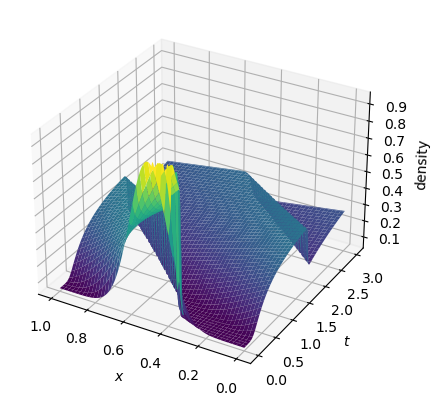

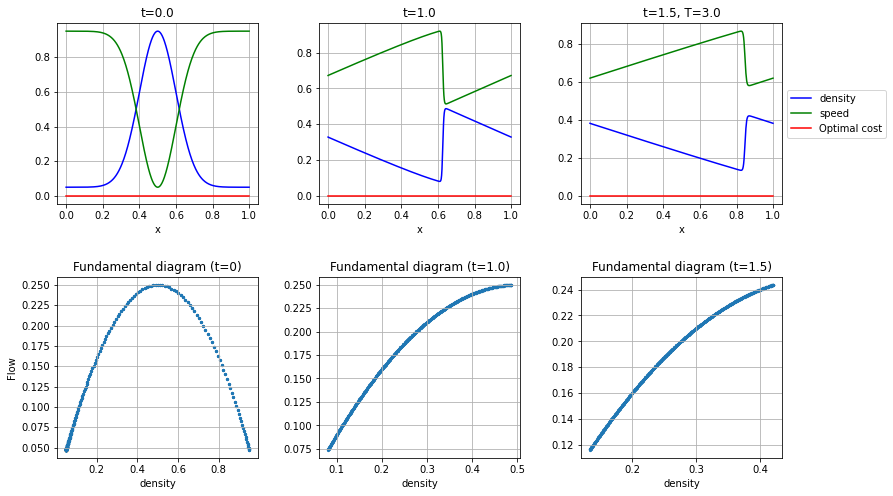

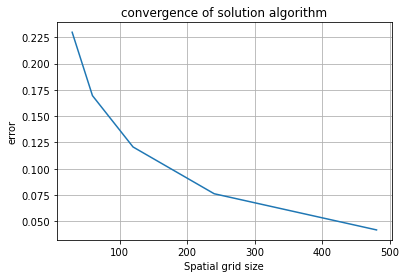

In [3]:
Error_list=[]
Nx_list=[]
mu=0.0
""" solve in coarse grid """
Nx=15; Nt=60 # spatial-temporal grid sizes 
sol0=np.loadtxt('lwr/Seq_Sol0_LWR_T3_N1.dat')

""" solve in finer grid 1 """
print("******* solve in finer grid 1 ********")
guess1=np.loadtxt('lwr/Seq_Guess1_LWR_T3_N1.dat')
sol1=np.loadtxt('lwr/Seq_Sol1_LWR_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess1,sol1,Error_list,Nx_list)

""" solve in finer grid 2 """
print("******* solve in finer grid 2 ********")
guess2=np.loadtxt('lwr/Seq_Guess2_LWR_T3_N1.dat')
sol2=np.loadtxt('lwr/Seq_Sol2_LWR_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess2,sol2,Error_list,Nx_list)

""" solve in finer grid 3 """
print("******* solve in finer grid 3 ********")
guess3=np.loadtxt('lwr/Seq_Guess3_LWR_T3_N1.dat')
sol3=np.loadtxt('lwr/Seq_Sol3_LWR_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess3,sol3,Error_list,Nx_list)

""" solve in finer grid 4 """
print("******* solve in finer grid 4 ********")
guess4=np.loadtxt('lwr/Seq_Guess4_LWR_T3_N1.dat')
sol4=np.loadtxt('lwr/Seq_Sol4_LWR_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess4,sol4,Error_list,Nx_list)

""" solve in finer grid 5 """
print("******* solve in finer grid 5 ********")
guess5=np.loadtxt('lwr/Seq_Guess5_LWR_T3_N1.dat')
sol5=np.loadtxt('lwr/Seq_Sol5_LWR_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess5,sol5,Error_list,Nx_list)

# print(Error_list)
""" Solutions """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol5,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)
y_mfg=np.zeros(len(x_mfg))
for i in range(1,len(x_mfg)):
    y_mfg[i]=(x_mfg[i-1]+x_mfg[i])/2
""" Plots """
plotting(t_mfg,x_mfg,y_mfg,rho_mfg,u_mfg,V_mfg,Q_mfg,Nx_list,Error_list)

## Separable

******* solve in finer grid 1 ********
Nx=30, Nt=180
dx=0.033, dt=0.017
******* solve in finer grid 2 ********
Nx=60, Nt=480
dx=0.017, dt=0.006
******* solve in finer grid 3 ********
Nx=120, Nt=1920
dx=0.008, dt=0.002


0

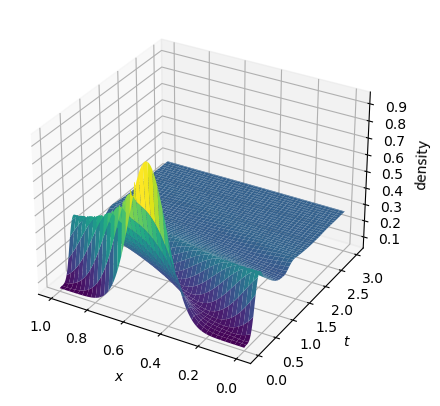

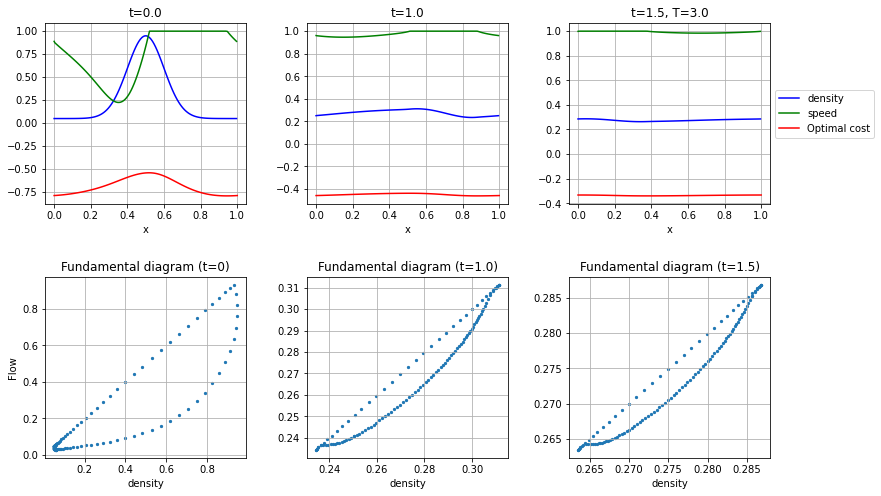

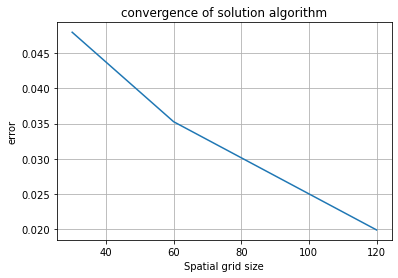

In [13]:
Error_list=[]
Nx_list=[]

""" solve in coarse grid """
Nx=15; Nt=68 # spatial-temporal grid sizes 
mu=0.045
sol0=np.loadtxt('sep/Seq_Sol0_Sep_T3_N1.dat')

""" solve in finer grid 1 """
print("******* solve in finer grid 1 ********")
mu=0.03
guess1=np.loadtxt('sep/Seq_Guess1_Sep_T3_N1.dat')
sol1=np.loadtxt('sep/Seq_Sol1_Sep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess1,sol1,Error_list,Nx_list)

""" solve in finer grid 2 """
print("******* solve in finer grid 2 ********")
mu=0.02
guess2=np.loadtxt('sep/Seq_Guess2_Sep_T3_N1.dat')
sol2=np.loadtxt('sep/Seq_Sol2_Sep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess2,sol2,Error_list,Nx_list)

""" solve in finer grid 3 """
print("******* solve in finer grid 3 ********")
guess3=np.loadtxt('sep/Seq_Guess3_Sep_T3_N1.dat')
sol3=np.loadtxt('sep/Seq_Sol3_Sep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess3,sol3,Error_list,Nx_list)

# print(Error_list)
""" Solutions """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol3,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)
y_mfg=np.zeros(len(x_mfg))
for i in range(1,len(x_mfg)):
    y_mfg[i]=(x_mfg[i-1]+x_mfg[i])/2
""" Plots """
plotting(t_mfg,x_mfg,y_mfg,rho_mfg,u_mfg,V_mfg,Q_mfg,Nx_list,Error_list)

## Non-Separable

******* solve in finer grid 1 ********
Nx=30, Nt=180
dx=0.033, dt=0.017
******* solve in finer grid 2 ********
Nx=60, Nt=720
dx=0.017, dt=0.004
******* solve in finer grid 3 ********
Nx=120, Nt=2880
dx=0.008, dt=0.001


0

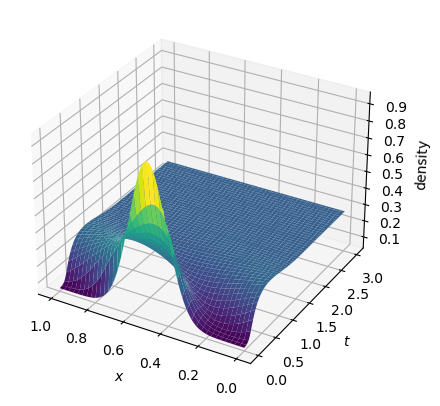

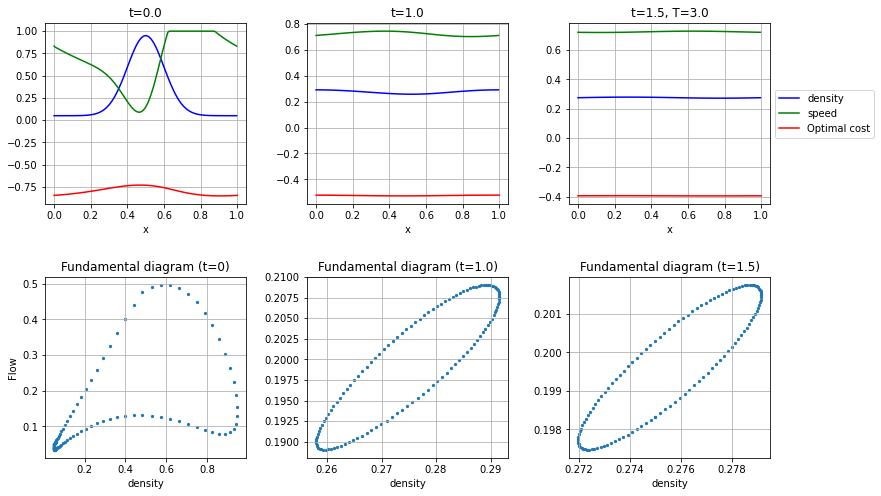

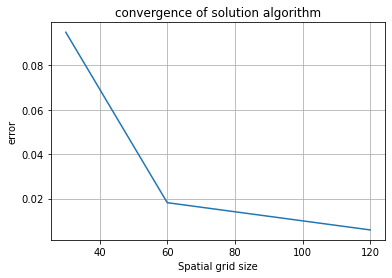

In [8]:
Error_list=[]
Nx_list=[]
mu=0.03

""" solve in coarse grid """
Nx=15; Nt=60 # spatial-temporal grid sizes 
sol0=np.loadtxt('nonsep/Seq_Sol0_NonSep_T3_N1.dat')

""" solve in finer grid 1 """
print("******* solve in finer grid 1 ********")
guess1=np.loadtxt('nonsep/Seq_Guess1_NonSep_T3_N1.dat')
sol1=np.loadtxt('nonsep/Seq_Sol1_NonSep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess1,sol1,Error_list,Nx_list)

""" solve in finer grid 2 """
print("******* solve in finer grid 2 ********")
guess2=np.loadtxt('nonsep/Seq_Guess2_NonSep_T3_N1.dat')
sol2=np.loadtxt('nonsep/Seq_Sol2_NonSep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess2,sol2,Error_list,Nx_list)

""" solve in finer grid 3 """
print("******* solve in finer grid 3 ********")
guess3=np.loadtxt('nonsep/Seq_Guess3_NonSep_T3_N1.dat')
sol3=np.loadtxt('nonsep/Seq_Sol3_NonSep_T3_N1.dat')
Nx,Nt=solve_grid(Nx,Nt,mu,guess3,sol3,Error_list,Nx_list)

# print(Error_list)
""" Solutions """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol3,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)
y_mfg=np.zeros(len(x_mfg))
for i in range(1,len(x_mfg)):
    y_mfg[i]=(x_mfg[i-1]+x_mfg[i])/2
""" Plots """
plotting(t_mfg,x_mfg,y_mfg,rho_mfg,u_mfg,V_mfg,Q_mfg,Nx_list,Error_list)